In [1]:
# Load some public modules in Python
import numpy as np
import pandas as pd
import pickle
import time
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from astropy.io import fits
from astropy.table import Table
import ray

# Import our original functions from other files
from Utility_fun import cart2sph, sph2cart
from DirLinProdSCMS_Ray import DirLinProdKDE_Fast, DirLinProdSCMSLog_Fast
# from DirLinearSCMS_Ray import DirLinSCMSLog_Fs, DirLinKDE_Fs

### 1.  SDSS-IV Data Pre-processing

We intend to detect the cosmic filaments using the observed galaxies in the Data Release 16 (DR16) (Ahumada et al., 2020) of the Sloan Digital Sky Survey (SDSS-IV). While the redshift values of recorded galaxies in the raw spectroscopic data file are too noisy, we obtain the galaxy data from the output of FIREFLY value-added catalog (Wilkinson et al., 2017) through the link (https://data.sdss.org/sas/dr16/eboss/spectro/firefly/v1_1_1/sdss_eboss_firefly-dr16.fits). 

The description of each column of the data file, namely, the data model, is on the website (https://data.sdss.org/datamodel/files/EBOSS_FIREFLY/FIREFLY_VER/sdss_eboss_firefly-DR16.html).

In [2]:
# Read the above Flexible Image Transport System (FITS) as a Table object
with fits.open('Data/sdss_eboss_firefly-dr16.fits') as hdulist:
    firefly_dr16 = Table.read(hdulist[1])

In [3]:
# Keep only the objects classified as galaxies with reliable and positive definite redshift values
firefly_dr16_1 = firefly_dr16[(firefly_dr16['CLASS_NOQSO'] == 'GALAXY') \
                              & (firefly_dr16['Z_NOQSO'] > firefly_dr16['Z_ERR_NOQSO']) \
                              & (firefly_dr16['Z_ERR_NOQSO'] > 0)]
# Subset some interested columns of the Table and convert it to a pandas DataFrame
col_lst = ['SPECOBJID', 'RUN2D', 'RUN1D', 'PLATE', 'MJD', 'FIBERID', 'RA', 'DEC', 'Z_NOQSO', 
           'Z_ERR_NOQSO', 'CLASS_NOQSO', 'Chabrier_MILES_total_mass']
gal_dat = firefly_dr16_1[col_lst].to_pandas()
del firefly_dr16, firefly_dr16_1

In [4]:
# Keep only the galaxies on the DR16 SDSS (RUN2D='26     ') and eBOSS (RUN2D='v5_13_0') spectra
SDSS_gal_dat = gal_dat.loc[gal_dat.RUN2D == '26     ']
eBOSS_gal_dat = gal_dat.loc[gal_dat.RUN2D == 'v5_13_0']
del gal_dat
comb_gal_dat = pd.concat([SDSS_gal_dat, eBOSS_gal_dat], axis=0, ignore_index=True)
del SDSS_gal_dat, eBOSS_gal_dat
comb_gal_dat.shape

(3606004, 12)

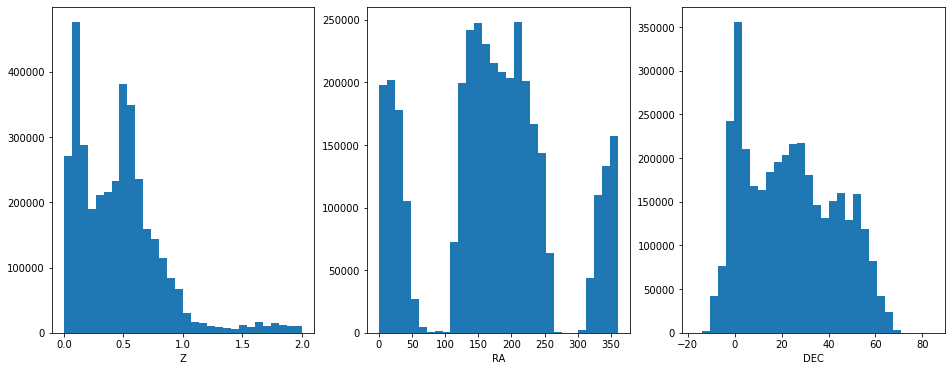

In [5]:
# Distributions of the redshift values, right ascensions, and declinations in the full galaxy data
plt.figure(figsize=(16,6))
plt.subplot(131)
plt.hist(comb_gal_dat.Z_NOQSO, bins=30)
plt.xlabel('Z')

plt.subplot(132)
plt.hist(comb_gal_dat.RA, bins=30)
plt.xlabel('RA')

plt.subplot(133)
plt.hist(comb_gal_dat.DEC, bins=30)
plt.xlabel('DEC')
plt.show()

### 2. Bandwidth Selection using all the galaxies on the North Galactic Cap ($100<RA<270$, $-5<DEC<70$) with redshift $0\leq z < 2$

In [6]:
z_l = 0
z_h = 2
comb_dat = comb_gal_dat.loc[(comb_gal_dat.Z_NOQSO >= z_l) & (comb_gal_dat.Z_NOQSO < z_h),:]
# Focus on the North galactic cap
comb_dat = comb_dat[(comb_dat.RA > 100) & (comb_dat.RA < 270) & (comb_dat.DEC > -5) & (comb_dat.DEC < 70)]
comb_dat_ang = comb_dat[['RA', 'DEC']].values
X, Y, Z = sph2cart(*comb_dat[['RA', 'DEC']].values.T)
comb_dat_cart = np.concatenate([X.reshape(-1,1), Y.reshape(-1,1), Z.reshape(-1,1)], axis=1)
gal_DirLin_full = np.concatenate([comb_dat_cart, comb_dat['Z_NOQSO'].values.reshape(-1,1)], axis=1)
gal_DirLin_full.shape

(2441941, 4)

In [7]:
# Computing the bandwidth using the full data
data = gal_DirLin_full
n = gal_DirLin_full.shape[0]
q = 2
D = 1
data_Dir = data[:,:(q+1)]
data_Lin = data[:,(q+1):(q+1+D)]
# Rule-of-thumb bandwidth selector for the directional component
R_bar = np.sqrt(sum(np.mean(data_Dir, axis=0) ** 2))
kap_hat = R_bar * (q+1 - R_bar ** 2) / (1 - R_bar ** 2)
h = (8*np.sinh(kap_hat)**2/(n*kap_hat * \
                 ((1+4*kap_hat**2)*np.sinh(2*kap_hat) - 2*kap_hat*np.cosh(2*kap_hat))))**(1/6)
bw_Dir = h
print('The current bandwidth for directional component is '+ str(bw_Dir) + '.\n')

# Normal reference rule of bandwidth selector for the linear component
b = (4/(D+2))**(1/(D+4))*(n**(-1/(D+4)))*np.mean(np.std(data_Lin, axis=0))
bw_Lin = b
print("The current bandwidth for linear component is "+ str(bw_Lin) + ".\n")

The current bandwidth for directional component is 0.03761226994489118.

The current bandwidth for linear component is 0.018697768900645576.



### 3. Cosmic Filament Detection on a Subset of SDSS-IV Data

As an illustrative example, we apply our proposed SCMS algorithm on $\Omega_2\times \mathbb{R}$ to the galaxy data (RA, DEC, Redshift) with redshift value $0.05 \leq z<0.07$. The first two (angular) coordinates will be converted to the corresponding Cartesian coordinates on $\Omega_2$.

All the density estimation and SCMS iterative steps are implemented via parallel programming under the Ray environment (https://www.ray.io/).

In [8]:
# Subset the galaxy data and convert every entry into a directional-linear form
z_l = 0.05
z_h = 0.07
comb_dat = comb_gal_dat[(comb_gal_dat.Z_NOQSO >= z_l) & (comb_gal_dat.Z_NOQSO < z_h)]
comb_dat = comb_dat[(comb_dat.RA > 100) & (comb_dat.RA < 270) & (comb_dat.DEC > -5) & (comb_dat.DEC < 70)]
comb_dat_ang = comb_dat[['RA', 'DEC']].values
comb_dat_mass = comb_dat['Chabrier_MILES_total_mass']
X, Y, Z = sph2cart(*comb_dat[['RA', 'DEC']].values.T)
comb_dat_cart = np.concatenate([X.reshape(-1,1), Y.reshape(-1,1), Z.reshape(-1,1)], axis=1)
gal_DirLin_dat = np.concatenate([comb_dat_cart, comb_dat['Z_NOQSO'].values.reshape(-1,1)], axis=1)
gal_DirLin_dat.shape

(97435, 4)

In [9]:
### Directional-linear kernel density estimation on the small galaxy dataset (Time-consuming step)
start = time.time()
ray.init(address='auto', _redis_password='5241590000000000')

mesh_0 = gal_DirLin_dat
dataset = gal_DirLin_dat
chunksize = 10
num_p = mesh_0.shape[0]
result_ids = []
for i in range(0, num_p, chunksize):
    result_ids.append(DirLinProdKDE_Fast.remote(mesh_0[i:(i+chunksize)], dataset, h=[bw_Dir, bw_Lin], 
                                                com_type=['Dir', 'Lin'], dim=[2,1]))
    # result_ids.append(DirLinKDE_Fs.remote(mesh_0[i:(i+chunksize)], dataset, h=bw_Dir, b=bw_Lin, q=2, D=1))
den_pts = ray.get(result_ids)
den_pts = np.concatenate(den_pts, axis=0)
ray.shutdown()
print("Elasped time: "+ str(time.time()-start)+'s.\n')

with open("./Data/DirLinKDE_z_l"+str(round(z_l, 3))+"z_h"+str(round(z_h, 3))+".dat", "wb") as file:
    pickle.dump([bw_Dir, bw_Lin, den_pts], file)

2021-10-11 01:54:28,889	INFO worker.py:727 -- Connecting to existing Ray cluster at address: 10.60.132.74:6379


Elasped time: 62.09819173812866s.



In [10]:
ray.shutdown()
ray.__version__

'1.4.0'

In [11]:
### Uncomment the following two lines of code if the output file of the preceding chunk is ready!!
### It helps save the time of running the preceding chunk!!
# with open("./Data/DirLinKDE_z_l"+str(round(z_l, 3))+"z_h"+str(round(z_h, 3))+".dat", "rb") as file:
#     bw_Dir, bw_Lin, den_pts = pickle.load(file)

# Remove the galaxies whose density values are lower than 20% quantile of density estimates on the entire dataset
gal_DirLin_dat_thres = gal_DirLin_dat[den_pts >= np.quantile(den_pts, 0.2)]
print("Thresholding Ratio: "+str(gal_DirLin_dat_thres.shape[0]/gal_DirLin_dat.shape[0]))
gal_DirLin_dat_thres.shape

Thresholding Ratio: 0.8


(77948, 4)

In [12]:
# Setting up the mesh points covering our interested region
nrows, ncols = (76, 171)
lon_m, lat_m, Z_m = np.meshgrid(np.linspace(100, 270, ncols), np.linspace(-5, 70, nrows), 
                                np.linspace(z_l, z_h, int((z_h-z_l)/0.002+1)))
xg, yg, zg = sph2cart(lon_m, lat_m)
mesh1 = np.concatenate([xg.reshape(-1,1), yg.reshape(-1,1), zg.reshape(-1,1), Z_m.reshape(-1,1)], axis=1)
mesh1.shape

(142956, 4)

In [13]:
### Directional-linear kernel density estimation on the entire mesh points (Time-consuming step)
start = time.time()
ray.init(address='auto', _redis_password='5241590000000000')

mesh_0 = mesh1
dataset = gal_DirLin_dat_thres
chunksize = 10
num_p = mesh_0.shape[0]
result_ids = []
for i in range(0, num_p, chunksize):
    result_ids.append(DirLinProdKDE_Fast.remote(mesh_0[i:(i+chunksize)], dataset, h=[bw_Dir, bw_Lin], 
                                                com_type=['Dir', 'Lin'], dim=[2,1]))
d_m_Dir = ray.get(result_ids)
d_m_Dir = np.concatenate(d_m_Dir, axis=0)
ray.shutdown()
print("Elasped time: "+ str(time.time()-start)+'s.\n')

with open("./Data/DirLinKDE_mesh_z_l"+str(round(z_l, 3))+"z_h"+str(round(z_h, 3))+".dat", "wb") as file:
    pickle.dump([bw_Dir, bw_Lin, d_m_Dir], file)

2021-10-11 01:55:31,110	INFO worker.py:727 -- Connecting to existing Ray cluster at address: 10.60.132.74:6379


Elasped time: 77.70420742034912s.



In [14]:
### Uncomment the following two lines of code if the output file of the preceding chunk is ready!!
### It helps save the time of running the preceding chunk!!
# with open("./Data/DirLinKDE_mesh_z_l"+str(round(z_l, 3))+"z_h"+str(round(z_h, 3))+".dat", "rb") as file:
#     bw_Dir, bw_Lin, d_m_Dir = pickle.load(file)

# Remove 20% of the mesh points with lower estimated density values
mesh1_thres = mesh1[d_m_Dir >= np.quantile(d_m_Dir, 0.2)]
print("Remaining mesh point ratio: "+str(mesh1_thres.shape[0]/mesh1.shape[0]))
mesh1_thres.shape

Remaining mesh point ratio: 0.80000139903187


(114365, 4)

In [15]:
# Our Proposed SCMS Algorithm on the denoised galaxy data with initial points as the thresholding mesh points
# (The most time-consuming step)
start = time.time()
ray.init(address='auto', _redis_password='5241590000000000')

mesh_0 = mesh1_thres
dataset = gal_DirLin_dat_thres
chunksize = 10
num_p = mesh_0.shape[0]
result_ids = []
for i in range(0, num_p, chunksize):
    result_ids.append(DirLinProdSCMSLog_Fast.remote(mesh_0[i:(i+chunksize)], dataset, d=1, h=[bw_Dir, bw_Lin], 
                                                    com_type=['Dir','Lin'], dim=[2,1], eps=1e-7, max_iter=5000))
SCMS_pts = ray.get(result_ids)
SCMS_pts = np.concatenate(SCMS_pts, axis=0)
ray.shutdown()
with open("./Data/DirLinSCMS_z_l"+str(round(z_l, 3))+"z_h"+str(round(z_h, 3))+".dat", "wb") as file:
    pickle.dump([bw_Dir, bw_Lin, SCMS_pts], file)
print("Elasped time: "+ str(time.time()-start)+'s.\n')

2021-10-11 01:56:48,843	INFO worker.py:727 -- Connecting to existing Ray cluster at address: 10.60.132.74:6379


(pid=153511) The SCMS algorithm in a directional/linear product space converges in 160 steps!
(pid=153542) The SCMS algorithm in a directional/linear product space converges in 164 steps!
(pid=153577) The SCMS algorithm in a directional/linear product space converges in 169 steps!
(pid=153465) The SCMS algorithm in a directional/linear product space converges in 171 steps!
(pid=153451) The SCMS algorithm in a directional/linear product space converges in 183 steps!
(pid=153555) The SCMS algorithm in a directional/linear product space converges in 175 steps!
(pid=153522) The SCMS algorithm in a directional/linear product space converges in 192 steps!
(pid=153529) The SCMS algorithm in a directional/linear product space converges in 165 steps!
(pid=153566) The SCMS algorithm in a directional/linear product space converges in 182 steps!
(pid=153486) The SCMS algorithm in a directional/linear product space converges in 217 steps!
(pid=153472) The SCMS algorithm in a directional/linear prod

### 4. Visualizing the Detected Filament Structure in $\mathbb{R}^3$ and its Projection onto the (RA,DEC) Space

If the outputs of Section 3 are ready, we can make the following plots by only pre-running the code in Section 1.

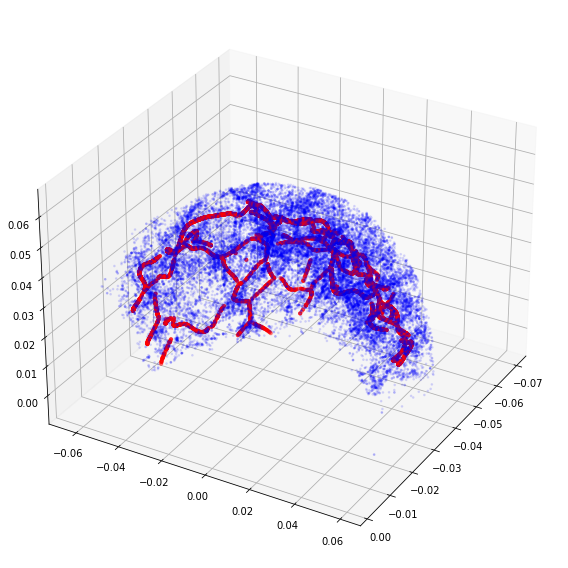

In [16]:
z_l = 0.05
z_h = 0.07
comb_dat = comb_gal_dat[(comb_gal_dat.Z_NOQSO >= z_l) & (comb_gal_dat.Z_NOQSO < z_h)]
comb_dat = comb_dat[(comb_dat.RA > 100) & (comb_dat.RA < 270) & (comb_dat.DEC > -5) & (comb_dat.DEC < 70)]
comb_dat_ang = comb_dat[['RA', 'DEC']].values
X, Y, Z = sph2cart(*comb_dat[['RA', 'DEC']].values.T)
comb_dat_cart = np.concatenate([X.reshape(-1,1), Y.reshape(-1,1), Z.reshape(-1,1)], axis=1)
gal_DirLin_dat = np.concatenate([comb_dat_cart, comb_dat['Z_NOQSO'].values.reshape(-1,1)], axis=1)

with open("./Data/DirLinSCMS_z_l"+str(round(z_l, 3))+"z_h"+str(round(z_h, 3))+".dat", "rb") as file:
    bw_Dir, bw_Lin, fila_3D_new = pickle.load(file)
    
np.random.seed(123)  ## Set an arbitrary seed for reproducibility
# Randomly subset 10000 filament points to reduce the size of yielded plot
ind1 = np.random.choice(fila_3D_new.shape[0], 10000)
lon, lat, R = cart2sph(*fila_3D_new[ind1,:3].T)
lat = (lat/180)*np.pi
lon[(lon >= -180) & (lon <= 0)] = lon[(lon >= -180) & (lon <= 0)] + 360
lon = (lon/180)*np.pi
Z_f = fila_3D_new[ind1,3] * np.sin(lat)
X_f = fila_3D_new[ind1,3] * np.cos(lat) * np.cos(lon)
Y_f = fila_3D_new[ind1,3] * np.cos(lat) * np.sin(lon)
fila_3D_map = np.concatenate([X_f.reshape(-1,1), Y_f.reshape(-1,1), Z_f.reshape(-1,1)], axis=1)

np.random.seed(123)  ## Set an arbitrary seed for reproducibility
# Randomly subset 30000 galaxy points to reduce the size of yielded plot
ind = np.random.choice(comb_dat_ang.shape[0], 30000)
comb_dat_ang_thres = comb_dat_ang[ind]
Z_thres = comb_dat['Z_NOQSO'].values[ind]
lon = (comb_dat_ang_thres[:,0]/180)*np.pi
lat = (comb_dat_ang_thres[:,1]/180)*np.pi
Z_p = Z_thres * np.sin(lat)
X_p = Z_thres * np.cos(lat) * np.cos(lon)
Y_p = Z_thres * np.cos(lat) * np.sin(lon)

Z_red = np.linspace(z_l, z_h, 100)
theta = np.linspace(-np.pi, np.pi, 100)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(30, 30)
ax.scatter3D(X_f, Y_f, Z_f, color='red', s=10)
ax.scatter3D(X_p, Y_p, Z_p, color='blue', alpha=0.1, s=3)
fig.tight_layout()
fig.savefig('./Figures/cosmic_fila_3D.pdf')

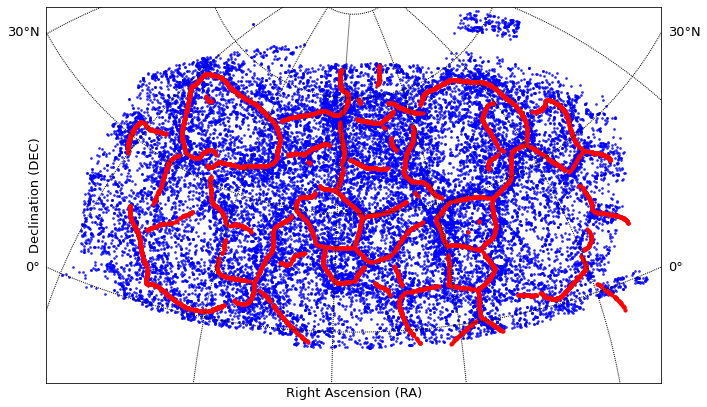

In [17]:
plt.rcParams.update({'font.size': 13})  ## Change the font sizes of ouput figures
fig = plt.figure(figsize=(10,8))
lon_f, lat_f, R = cart2sph(*fila_3D_new[ind1,:3].T)
lon_f[(lon_f >= -180) & (lon_f <= 0)] = lon_f[(lon_f >= -180) & (lon_f <= 0)] + 360
lon_p = comb_dat_ang[ind,0]
lat_p = comb_dat_ang[ind,1]
m1 = Basemap(width=18000000,height=11000000, resolution='l',projection='stere', lat_ts=50,lat_0=35,lon_0=185)
m1.drawmeridians(np.arange(0, 360, 30), labels=[0,0,0,0])
m1.drawparallels(np.arange(-90, 90, 30), labels=[1,1,0,1])
x_f, y_f = m1(lon_f, lat_f)
x_p, y_p = m1(lon_p, lat_p)
cs = m1.scatter(x_p, y_p, color='blue', s=3, alpha=0.7)
cs = m1.scatter(x_f, y_f, color='red', s=10)
fig.tight_layout()
plt.xlabel('Right Ascension (RA)')
plt.ylabel('Declination (DEC)')
fig.savefig('./Figures/cosmic_fila_2D.pdf')